# THE WAR AGAINST HEART ARRHYTHMIA

In [2]:
import numpy as np
from scipy.optimize import fsolve
import math
import pywt
import cython
import pandas as pd
import scipy.signal
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from statsmodels.tsa.stattools import acf
import random
from collections import deque
import statsmodels.graphics.tsaplots as st
from scipy import special
from scipy.signal import find_peaks
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy import integrate
import pyspeckit
from pyspeckit import moments
import arch
from arch.unitroot import VarianceRatio

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Loading and viewing the data

In [3]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\ahmad\\Desktop\\UC3M\\Thesis\\Python_Workspace\\Code_thesis\\War_on_arrhythmia'

In [4]:
MIT_signal_head = wfdb.io.rdrecord("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/vfdb/418")
MIT_signal_head.record_name

'418'

In [5]:
MIT_signal_whole = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/111")

def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data

MIT_data = signal_creator(MIT_signal_whole)
MIT_data

array([-0.035, -0.035, -0.035, ...,  0.155,  0.2  ,  0.   ])

Annotation and signal type

In [6]:
ann = wfdb.rdann('C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/vfdb/422', 'atr')
[ann.sample,ann.symbol]
np.array(ann.aux_note).tolist()

['(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(NOISE',
 '(N',
 '(VT',
 '(N',
 '(VT',
 '(NOISE',
 '(VFIB',
 '(NOISE',
 '(VFIB',
 '(NOISE',
 '(VFIB',
 '(NOISE']

In [7]:
MIT_signal_whole[1]

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V1'],
 'comments': ['47 F 937 167 x1',
  'Digoxin, Lasix',
  'There is first degree AV block.  There are short bursts of both baseline',
  'shifts and muscle noise, but in general, the quality is excellent.']}

In [8]:
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [9]:
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


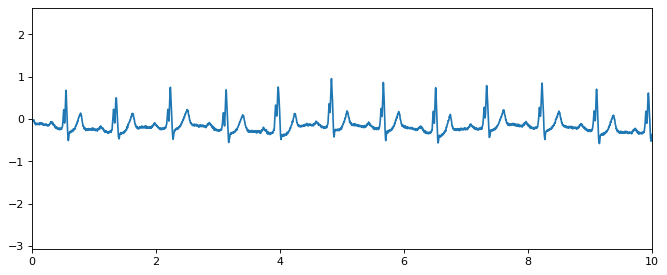

In [10]:
fs = 360
time = np.arange(MIT_data.size)/fs
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_data)

# Signal preprocessing:

1. Subtract the mean
2. Five order moving average filtering
3. High Pass Filtering with f = 1 Hz (Drift Suppression)
4. low-pass Butterworth filtering with fc = 30 Hz

In [11]:
def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

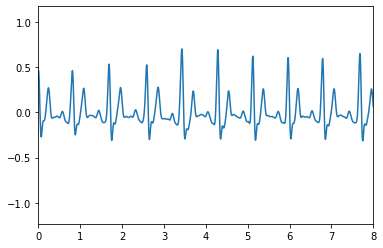

In [12]:
MIT_signal,time = signal_preprocessor(MIT_data,time,360,30) ##250 cudb vfdb and 360 MITDB
MIT_signal,time = starting_point(MIT_signal,time,360)
plt.xlim(0,8)
plt.plot(time,MIT_signal)


(0, 10)

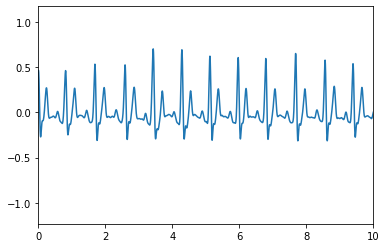

In [13]:
MIT_signal,time = starting_point(MIT_signal,time,360)
plt.plot(time,MIT_signal)
plt.xlim(0,10)

# Time parameter

In [14]:
t_cst = len(MIT_signal)/time[-1]
t_cst  ##number of signal points in 1 second

360.00055401491534

## Parameter 1: TCI

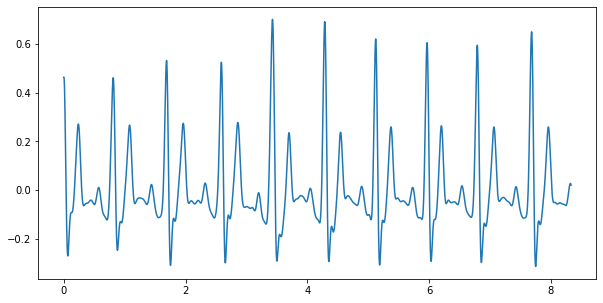

In [15]:
MIT_signal.size
time.size
time[300]
time[600]
plt.figure(figsize=(10,5))
plt.plot(time[0:3000],MIT_signal[0:3000])

In [16]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(MIT_signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    return np.array(binary_list),threshold

array([1, 1, 1, ..., 0, 0, 0])

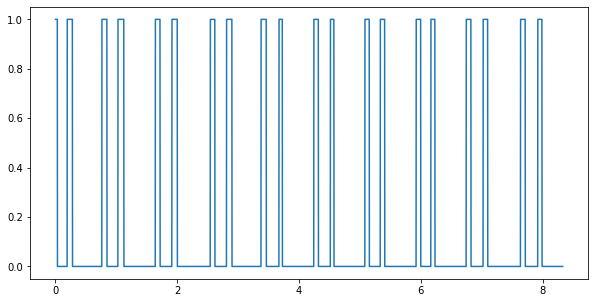

In [17]:
binlist,thd = binary_td(MIT_signal,0,10)
plt.figure(figsize=(10,5))
plt.plot(time[0:10*300],binlist)
binlist[300:2700]

In [18]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        if t1+t2 == 0:
            TCI.append(0)
        elif t3+t4==0:
            TCI.append(0)
        else:
            form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
            if form1 == 0:
                TCI.append(0)
            else:
                form2=1000/form1
                TCI.append(form2)
            q+=300
            p+=300
            k+=1
    return np.array(TCI)

In [19]:
binlist,thd = binary_td(MIT_signal,0,10)
TCI(binlist,thd,1,9)

array([663.95864106, 482.26709656, 502.72802752, 514.73349244,
       503.35001024, 503.37946572, 494.91313195, 526.4532985 ])

# Parameter 2: ACF Algorithm

In [20]:
qrs_inds = processing.xqrs_detect(sig=MIT_signal[0:2400], fs=85)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


15

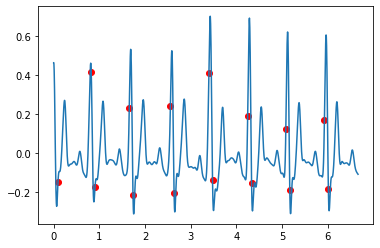

In [21]:
plt.plot(time[0:2400],MIT_signal[0:2400])
plt.scatter(time[qrs_inds],MIT_signal[qrs_inds],color="red")
x = int(len(qrs_inds))
x

In [22]:
ser = acf(MIT_signal[0:2400],nlags=x*3,alpha=0.01)

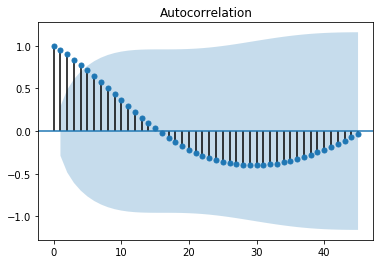

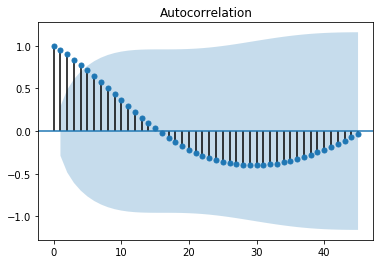

In [23]:
st.plot_acf(ser[0])

In [24]:
vr = VarianceRatio(ser[0])
vr.overlap=False
vr.stat


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



4.633045293067376

In [25]:
def ACF_test(signal):
    qrs_inds = processing.xqrs_detect(sig=signal, fs=85)
    x = int(len(qrs_inds))
    ser = acf(signal,nlags=x*3,alpha=0.05)
    vr = VarianceRatio(ser[0])
    vr.overlap=False
    return vr.stat

In [26]:
ACF_test(MIT_signal[0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.



The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



4.633045293067376

## Parameter 3: VF Filter

In [27]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def VF_Filter_leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [28]:
VF_Filter_leakage(MIT_signal,int(get_points(MIT_signal,300)),200,500)

0.583943430087362

## Parameter 4: Spectral Algorithm

In [29]:
Ham = MIT_signal[0:2400]*np.hamming(2400)

(-120, 120)

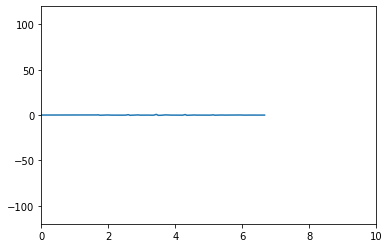

In [30]:
plt.plot(time[0:2400],Ham)
plt.xlim(0,10)
plt.ylim(-120,120)

In [31]:
fourier = scipy.fft(Ham)

In [32]:
fourier

array([-0.22628347+0.j        , -0.22701253+0.02394437j,
       -0.23126225+0.04699765j, ..., -0.22889275-0.10295006j,
       -0.23126225-0.04699765j, -0.22701253-0.02394437j])

Casting complex values to real discards the imaginary part


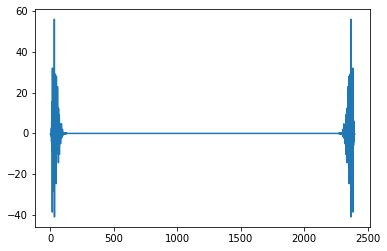

In [33]:
plt.plot(fourier)

In [34]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [35]:
fourier_2 = fourier_abs(fourier).real

In [36]:
fourier_2

array([0.22628347, 0.2509569 , 0.2782599 , ..., 0.33184282, 0.2782599 ,
       0.2509569 ])

(0, 10)

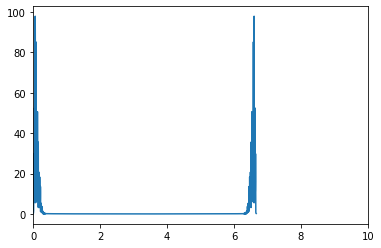

In [37]:
plt.plot(time[0:2400],fourier_2)
plt.xlim(0,10)

In [38]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [39]:
time_2

2.0

In [40]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

13
50.614812928583326


In [41]:
f.index(m)

13

In [42]:
f[6]

25.378390237140998

In [43]:
time_max_amp = f.index(m)/300 ## in seconds
if time_max_amp != 0:
    God_of_War = 1/time_max_amp
else:
    God_of_War = 0
God_of_War

23.076923076923077

In [44]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [45]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0., 0., 0., ..., 0., 0., 0.])

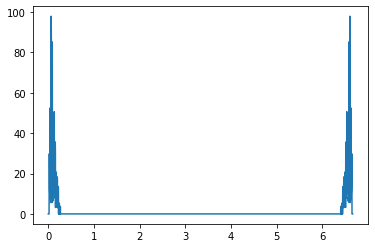

In [46]:
plt.plot(time[0:2400],fourier_final)

In [47]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


<Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at -0x7fffffe57d57ef1c>

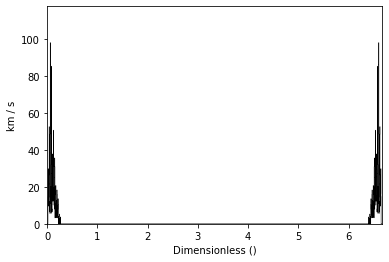

In [48]:
pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],doplot="True",unit ='km / s' )

In [49]:
Mk = pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],unit = 'km / s').moments
Mk

<bound method BaseSpectrum.moments of <Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at 0x1a82a82b86>>

In [50]:
np.minimum(1,2)

1

In [51]:
sum(MIT_signal[0:2400])

-2.938399091551117

In [52]:
def A_calc(f1,f2,f3,f4,signal):
    i1 = int((f1)*300)
    i2 = int((f2)*300)
    i3 = int((f3)*300)
    i4 = int((f4)*300)
    
    if i1<i2:
        A=0
        for i in range(len(signal[i1:i2])):
            A += signal[i]
    else:
        A=0
        for i in range(len(signal[i2:i1])):
            A += signal[i]
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])

    return (A/B)

In [53]:
A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
A1

1.0000000000000007

In [54]:
A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),MIT_signal[0:2400])
A2

-0.0

In [55]:
A = np.arange(2*God_of_War,8*God_of_War,0.6)
A = ((1/A)*t_cst).astype(int)
A = np.unique(A)
A

array([1, 2, 3, 4, 5, 6, 7])

In [56]:
def A3_calc(signal,God_of_War):
    A = np.arange(2*God_of_War,8*God_of_War,0.6)
    A = ((1/A)*t_cst).astype(int)
    A = np.unique(A)
    A = sum(signal[A])
    
    i3 = int((1/0.5)*300)
    i4 = int(1/np.minimum(20*God_of_War,100))
    
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return A/B

In [57]:
A3_calc(MIT_signal[0:2400],God_of_War)

-1.0240904109272688

In [58]:
def SPEC(signal):
    Ham = signal*np.hamming(2400)
    fourier = scipy.fft(Ham)
    fourier_2 = fourier_abs(fourier).real
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = fourier_2[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    fourier_final = amp_maxsetter(fourier_2,m)
    
    A3 = A3_calc(fourier_2,God_of_War)
    
    return A3

In [59]:
SPEC(MIT_signal[0:2400])

0.009584663943600327

## Parameter 5: Complexity Measure Algorithm

In [60]:
nurgle = MIT_signal[0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

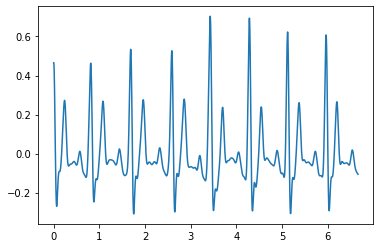

In [61]:
plt.plot(time[0:2400],nurgle)

In [62]:
def Td(nurgle):
    meanbean = np.mean(nurgle)
    nurgle = nurgle - meanbean
    Vp = np.amax(nurgle)
    Vn = np.amin(nurgle)
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [63]:
Threshold = Td(nurgle)
Threshold

0

In [64]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [65]:
binary = binary_comp(Threshold,nurgle)
binary

array([1, 1, 1, ..., 0, 0, 0])

In [66]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary,length):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    bn = length/(math.log2(length))
    
    return cn/bn

In [67]:
def complexity_measure(nurgle,length):
    Threshold = Td(nurgle)
    binary = binary_comp(Threshold,nurgle)
    return complexity(binary,length)

In [68]:
def comp_measure(signal,length):
    l = 0
    k = 0
    j = 300
    for i in range(0,8):
        l += complexity_measure(signal[k:j],length)
        k+=300
        j+=300
    return l

In [69]:
comp_measure(MIT_signal,2400)

0.21521902490117104

## Parameter 6: Standard Exponential Algorithm

In [80]:
def std_exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

165.0

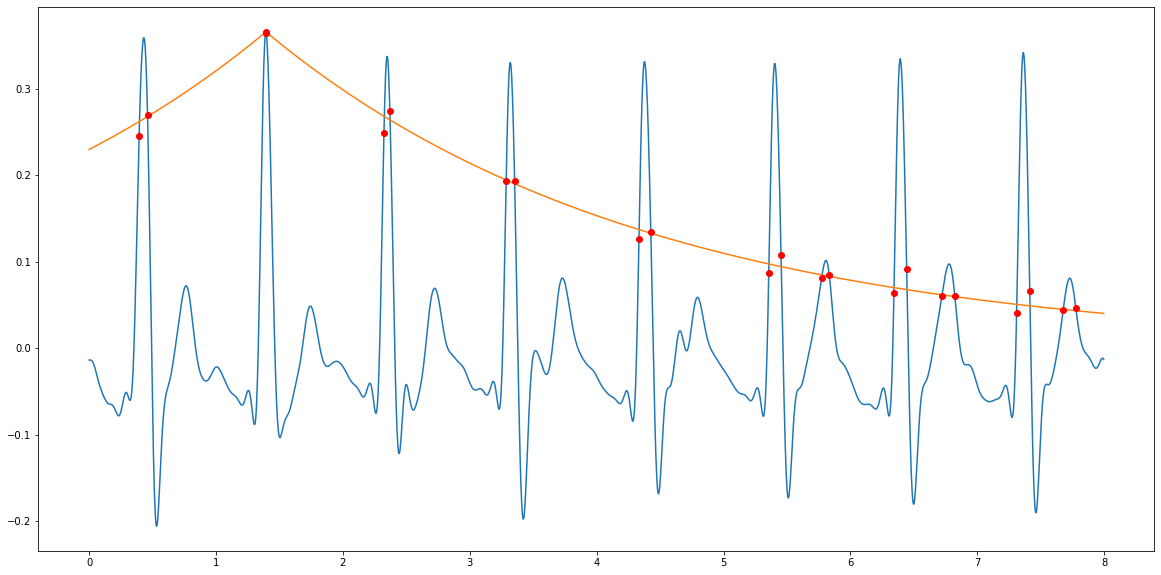

In [81]:
std_exp_algthm(tt[2][0][0:2400],ss[2][0][0:2400],3)

In [82]:
time

array([0.00000000e+00, 2.77777778e-03, 5.55555556e-03, ...,
       1.80500000e+03, 1.80500278e+03, 1.80500556e+03])

In [83]:
tt[0][0]

array([0.00000000e+00, 3.33333333e-03, 6.66666667e-03, ...,
       1.10466667e+01, 1.10500000e+01, 1.10533333e+01])

## Parameter 7: Modified Exponential Algorithm

In [150]:
### Note that the function only works by the book if the starting point is a maximum

def MEA(t,signal,Tau):
    real_curve = [1.0]*len(t)
    index_M  = argrelextrema(signal,np.greater)
    idx_M = index_M[0]
    gladiator = np.amax(signal)
    idx_M2 = []
    for i in idx_M:
        if signal[i]>0.2*gladiator:
            idx_M2.append(i)
    idx_M2 = np.array(idx_M2)
    idx_M1 = []
    for i in idx_M:
        if signal[i]>0.1*gladiator:
            idx_M1.append(i)
    idx_M1 = np.array(idx_M1)
    
    ## draw the first curve
    pt = 0
    qqq = 0
    lifts=0
    while 2 < 3: 
        if pt >= idx_M[-1]: 
            break
        M1 = signal[pt]
        tm1 = t[pt]
        curve_1 = M1*np.exp(-1*(t-tm1)/(Tau))
        idx_1 = np.argwhere(np.diff(np.sign(signal-curve_1))).flatten()
        for i in idx_1:
            if i > 10+pt:
                idx_work = i
                break
        ## find all the maxes 
        for j in range(len(idx_M)):
            if idx_work <= idx_M[j]:
                idx_M_work = idx_M[j]
                break
        real_curve[pt:idx_work] = (curve_1[pt:idx_work])
        real_curve[idx_work:idx_M_work]=(signal[idx_work:idx_M_work])
        pt = idx_M_work
        if pt ==qqq:
            break
        qqq = idx_M_work
        lifts+=1
        if pt >= idx_M[-1]:     ### Also note that the main problem with the algorithm is that I don't know what I should set as a condition to end the function yet
            break
    idx_final = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    #plt.figure(figsize=(20,10))
    #plt.plot(t,signal,color="blue")
    #plt.plot(t,real_curve,color="green")
    #plt.plot(t[idx_final],signal[idx_final],'ro')
    pt=idx_M_work
    Time_length = t[pt]-t[0]
    form = lifts/Time_length
    return form*60

In [151]:
MEA(tm[37][0:2400],sm[37][0:2400],0.2)

144.32071269487753

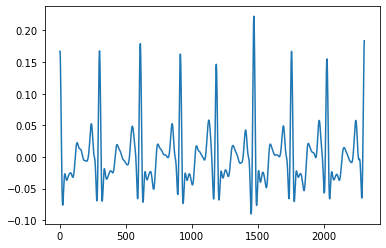

In [100]:
plt.plot(sm[37])

In [86]:
def MEA(t,signal,Tau):
    real_curve = [1.0]*len(t)
    index_M  = argrelextrema(signal,np.greater)
    idx_q = index_M[0]
    idx_M = []
    for i in idx_q:
        if i>0:
            idx_M.append(i)
    idx_M = np.array(idx_M)
    pt = 0
    lifts = 0
    curve = signal[0]*np.exp(-1*(t-tm1)/(Tau))
    idx_1 = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    
    while 2 < 3:
        if len(idx_1)
        next_max = 0
        for i in idx_M:
            if idx_1[0]<=i:
                next_max = i
            else:
                next_max = signal[-1]
        
        

SyntaxError: invalid syntax (<ipython-input-86-269339334826>, line 16)

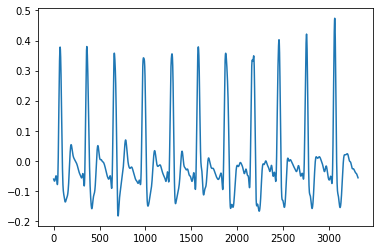

In [87]:
plt.plot(ss[2][34])

In [ ]:
index_M  = argrelextrema(ss[2][34][0:2400],np.greater)
idx_q = index_M[0]
gladiator = np.amax(ss[2][34])
idx_M = []
for i in idx_q:
    if ss[2][34][i]>0.000005*gladiator:
        idx_M.append(i)

In [ ]:
plt.plot(tt[2][34][0:2400],ss[2][34][0:2400])
plt.scatter(tt[2][34][idx_M],ss[2][34][idx_M],color="Red")

In [ ]:
## take the max after the 8 second interval where the first lift after that will happen
q = argrelextrema(MIT_signal[0:3300],np.greater)
q

In [ ]:
q[0][0]

In [ ]:
q = wfdb.processing.find_peaks(MIT_signal[0:2800])[0]

In [ ]:
plt.plot(time[0:2800],MIT_signal[0:2800])
plt.scatter(time[q],MIT_signal[q],color="red")

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(MIT_signal[0:2444])

In [ ]:
fs=360
s1 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/101")
s1 = signal_creator(s1)
t1 = np.arange(s1.size)/fs
s1,t1= signal_preprocessor(s1,t1,360,30)

In [ ]:
## Make sure to specify the time interval, take the starting point to be a maximum, and the end point 
## to be a maximum where a lift is likely to happen
def MEA_solver(signal,time):
    q = argrelextrema(signal[0:3300],np.greater)[0]
    return MEA(time[0:q[-2]],signal[0:q[-2]],0.2)

In [ ]:
MEA_solver(MIT_signal,time)

## Parameter 8: Signal Comparison

In [ ]:
signal = MIT_signal[0:2400]
signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
time_1 = time[0:2400]
qrs_inds = processing.xqrs_detect(sig=signal, fs=85)

In [ ]:
wfdb.plot_items(signal=signal, ann_samp=[qrs_inds])
qrs_inds

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(time_1,signal)
plt.scatter(time_1[qrs_inds],signal[qrs_inds],color="red")

Let's create the first signal:

In [ ]:
MIT_signal_1 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/102")

MIT_data_1 = signal_creator(MIT_signal_1)

fs = 360
time = np.arange(MIT_data_1.size)/fs
MIT_signal_1,time_2 = signal_preprocessor(MIT_data_1,time,360,30)
MIT_signal_1 = wfdb.processing.normalize_bound(MIT_signal_1, lb=0, ub=1)
MIT_signal_1,time_2

Adjust the peaks to match the QRS points found for the signal we want to examine:

In [ ]:
SCA_1 = MIT_signal_1[0:2400]
qrs_inds_2 = processing.xqrs_detect(sig=SCA_1, fs=45)

In [ ]:
plt.plot(time_1,SCA_1)
plt.scatter(time_1[qrs_inds_2],SCA_1[qrs_inds_2],color = "red")

Now to create the second signal:

In [ ]:
fs=360
s1 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/101")
s1 = signal_creator(s1)
t1 = np.arange(s1.size)/fs
s1,t1= signal_preprocessor(s1,t1,360,30)
#s1 = wfdb.processing.normalize_bound(s1, lb=-1, ub=1)

s2 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/103")
s2 = signal_creator(s2)
t2 = np.arange(s2.size)/fs
s2,t2= signal_preprocessor(s2,t2,360,30)
#s2 = wfdb.processing.normalize_bound(s2, lb=-1, ub=1)

s3 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/105")
s3 = signal_creator(s3)
t3 = np.arange(s3.size)/fs
s3,t3= signal_preprocessor(s3,t3,360,30)
#s3 = wfdb.processing.normalize_bound(s3, lb=-1, ub=1)

s4 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/106")
s4 = signal_creator(s4)
t4 = np.arange(s4.size)/fs
s4,t4= signal_preprocessor(s4,t4,360,30)
#s4 = wfdb.processing.normalize_bound(s4, lb=-1, ub=1)

s5 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/108")
s5 = signal_creator(s5)
t5 = np.arange(s5.size)/fs
s5,t5= signal_preprocessor(s5,t5,360,30)
#s5 = wfdb.processing.normalize_bound(s5, lb=-1, ub=1)

s6 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/109")
s6 = signal_creator(s6)
t6 = np.arange(s6.size)/fs
s6,t6= signal_preprocessor(s6,t6,360,30)
#s6 = wfdb.processing.normalize_bound(s6, lb=-1, ub=1)

s7 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/111")
s7 = signal_creator(s7)
t7 = np.arange(s7.size)/fs
s7,t7= signal_preprocessor(s7,t7,360,30)
#s7 = wfdb.processing.normalize_bound(s7, lb=-1, ub=1)

s8 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/112")
s8 = signal_creator(s8)
t8 = np.arange(s8.size)/fs
s8,t8= signal_preprocessor(s8,t8,360,30)
#s8 = wfdb.processing.normalize_bound(s8, lb=-1, ub=1)

s9 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/113")
s9 = signal_creator(s9)
t9 = np.arange(s9.size)/fs
s9,t9= signal_preprocessor(s9,t9,360,30)
#s9 = wfdb.processing.normalize_bound(s9, lb=-1, ub=1)

s10 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/114")
s10 = signal_creator(s10)
t10 = np.arange(s10.size)/fs
s10,t10= signal_preprocessor(s10,t10,360,30)
#s10 = wfdb.processing.normalize_bound(s10, lb=-1, ub=1)

s11 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/115")
s11 = signal_creator(s11)
t11 = np.arange(s11.size)/fs
s11,t11= signal_preprocessor(s11,t11,360,30)
#s11 = wfdb.processing.normalize_bound(s11, lb=-1, ub=1)

s12 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/116")
s12 = signal_creator(s12)
t12 = np.arange(s12.size)/fs
s12,t12= signal_preprocessor(s12,t12,360,30)
#s12 = wfdb.processing.normalize_bound(s12, lb=-1, ub=1)

s13 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/117")
s13 = signal_creator(s13)
t13 = np.arange(s13.size)/fs
s13,t13= signal_preprocessor(s13,t13,360,30)
#s13 = wfdb.processing.normalize_bound(s13, lb=-1, ub=1)

s14 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/118")
s14 = signal_creator(s14)
t14 = np.arange(s14.size)/fs
s14,t14= signal_preprocessor(s14,t14,360,30)
#s14 = wfdb.processing.normalize_bound(s14, lb=-1, ub=1)

s15 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/119")
s15 = signal_creator(s15)
t15 = np.arange(s15.size)/fs
s15,t15= signal_preprocessor(s15,t15,360,30)
#s15 = wfdb.processing.normalize_bound(s15, lb=-1, ub=1)

s16 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/121")
s16 = signal_creator(s16)
t16 = np.arange(s16.size)/fs
s16,t16= signal_preprocessor(s16,t16,360,30)
#s16 = wfdb.processing.normalize_bound(s16, lb=-1, ub=1)

In [ ]:
plt.xlim(0,2400)
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)
plt.plot(s4)
plt.plot(s5)
plt.plot(s6)
plt.plot(s7)
plt.plot(s8)
plt.plot(s9)
plt.plot(s10)
plt.plot(s11)
plt.plot(s12)
plt.plot(s13)
plt.plot(s14)
plt.plot(s15)
plt.plot(s16)

In [ ]:
def signal_size_adjustor(signal):
    k = len(signal)-1
    m = np.mean(signal)
    signal = signal.tolist()
    while k < 650000:
        signal.append(m)
        k+=1
    time = np.arange(np.array(signal).size)/300
    return np.array(signal),time

In [ ]:
def starting_point_2(signal,t):
    M = np.amax(signal[8:500])
    ss = signal.tolist()
    index_M = ss.index(M)
    signal_start = signal[index_M:-1]
    fs=300
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

In [ ]:
sig_array = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16]
time_array = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]
sig_1 = []
sig_2 = []
for i in range(0,16):
    x,y = starting_point_2(sig_array[i],time_array[i])
    sig_1.append(x)
    sig_2.append(y)

In [ ]:
ss = s1
M = np.amax(s1[8:500])
sss = ss.tolist()
sss.index(M)

In [ ]:
plt.xlim(0,2400)
plt.plot(sig_1[0])
plt.plot(sig_1[1])
plt.plot(sig_1[2])
plt.plot(sig_1[3])

In [ ]:
sig_3 = []
sig_4 = []
for i in range(0,16):
    x,y = signal_size_adjustor(sig_1[i])
    sig_3.append(x)
    sig_4.append(y)

In [ ]:
avg = []
for i in range(0,650001):
    avg.append(0)
avg = np.array(avg)
for i in sig_3:
    avg = avg + i
avg = avg/len(sig_3)

In [ ]:
SCA_2 = avg
SCA_2,t1= signal_preprocessor(SCA_2,sig_4[0],360,50)
plt.xlim(0,8)
plt.plot(t1,SCA_2)

In [ ]:
plt.plot(t1, signal_second)
plt.xlim(0,10)

Now for the third signal, it just has an elevated T wave:

In [ ]:
SCA_3 = wfdb.io.rdsamp("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/107")
SCA_3 = signal_creator(SCA_3)
time_third = np.arange(SCA_3.size)/fs
SCA_3,time_third= signal_preprocessor(SCA_3,time_third,360,30)

For the fourth signal:

In [ ]:
x = []
spacing1 = len(signal)/(len(qrs_inds)-1)
for i in range(len(signal[qrs_inds])-1):
    spacing2 = (signal[qrs_inds[i+1]] - signal[qrs_inds[i]])/spacing1
    y = np.arange(signal[qrs_inds[i]],signal[qrs_inds[i+1]],spacing2) ##Needs to be a formula
    for i in y:
        x.append(i)
x = np.array(x)
SCA_4 = np.cos(x)
plt.plot(SCA_4)
len(SCA_4)
SCA_4 = np.resize(SCA_4,(2400,))

Now for the residual calculation

In [ ]:
I0 = qrs_inds[0]
I1 = qrs_inds[-1]

In [ ]:
def Integral_calc(S,F,I0,I1):
    y = np.absolute(S-F)
    R = integrate.simps(y[I0:I1])
    return R

In [ ]:
RF   = Integral_calc(signal,SCA_4,I0,I1)
RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
print("RF = ",RF)
print("RFS1 = ",RFS1)
print("RFS2 = ",RFS2)
print("RFS3 = ",RFS3)

In [ ]:
IF  = Integral_calc(SCA_4,0,I0,I1)
IE  = Integral_calc(signal,0,I0,I1)
IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)

print("IF = ",IF)
print("IE = ",IE)
print("IS1 = ",IS1)
print("IS2 = ",IS2)
print("IS3 = ",IS3)

In [ ]:
VRF = (RF/min(IF,IE))
VRS1 = RFS1/min(IS1,IE)
VRS2 = RFS2/min(IS2,IE)
VRS3 = RFS3/min(IS3,IE)

print("VRF = ",VRF)
print("VRS1 = ",VRS1)
print("VRS2 = ",VRS2)
print("VRS3 = ",VRS3)

In [ ]:
t1 = VRF/VRS1
t2 = VRF/VRS2
t3 = VRF/VRS3

print("t1 = ",t1)
print("t2 = ",t2)
print("t3 = ",t3)

In [ ]:
x= [1,2,3]
np.array(x)

In [ ]:
def SCA(signal):
    
    signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
    qrs_inds = processing.xqrs_detect(sig=signal, fs=85)
    
    I0 = qrs_inds[0]
    I1 = qrs_inds[-1]
    
    RF   = Integral_calc(signal,SCA_4,I0,I1)
    RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
    RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
    RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
    IF  = Integral_calc(SCA_4,0,I0,I1)
    IE  = Integral_calc(signal,0,I0,I1)
    IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
    IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
    IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)
    VRF = (RF/min(IF,IE))
    VRS1 = RFS1/min(IS1,IE)
    VRS2 = RFS2/min(IS2,IE)
    VRS3 = RFS3/min(IS3,IE)
    t1 = VRF/VRS1
    t2 = VRF/VRS2
    t3 = VRF/VRS3
    
    l = [t1,t2,t3]
    
    return np.array(l)

In [ ]:
SCA(MIT_signal[0:2400])

How do I take the average of the signals?

# Parameter 9: Wavelet Based Algorithms

## Wavelet 1:

In [ ]:
pywt.wavelist()

In [ ]:
wavelet1 = pywt.cwt(MIT_signal,200,"mexh")
plt.plot(wavelet1[0][0])
plt.xlim(0,4800)

In [ ]:
fourier1 = fft(wavelet1[0][0])
plt.plot(fourier1)

In [ ]:
freq_cst = (1/(np.sqrt(2*np.pi)))

In [ ]:
fourier1 = np.absolute(fourier1)
fourier1 = freq_cst*fourier1
plt.plot(fourier1)

In [ ]:
M = argrelextrema(fourier1,np.greater)[0]
plt.plot(time[0:len(fourier1)],fourier1)
plt.scatter(time[M],fourier1[M],color='red')
plt.xlim(0,10)

In [ ]:
plt.plot(fourier1[M[0:2400]])
len(fourier1[M[0:2400]])

In [ ]:
def SPEC2(signal):
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = signal[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    A3 = A3_calc(signal,God_of_War)
    
    return A3

In [ ]:
SPEC2(fourier1[M[0:2400]])

In [ ]:
def wavelet_one(signal):
    wavelet1 = pywt.cwt(signal,200,"mexh")
    fourier1 = fft(wavelet1[0][0])
    freq_cst = (1/(np.sqrt(2*np.pi)))
    fourier1 = np.absolute(fourier1)
    fourier1 = freq_cst*fourier1
    M = argrelextrema(fourier1,np.greater)[0]
    
    return SPEC2(fourier1[M[0:2400]])

In [ ]:
wavelet_one(MIT_signal[0:2400])

## Wavelet 2:

Need to turn the SPEC algorithm into one big algorithm. This uses SPEC to check whether the signal is VF, if it is, then this second wavelet does not need to be considered. If it doesn't however, the following is performed:

In [ ]:
w = pywt.dwt(MIT_signal[0:2400],'db8','smooth')
plt.plot(w[0])

In [ ]:
plt.plot(w[1])

In [ ]:
qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
len(qrs_wave2)/3

In [ ]:
def Wave_2(signal):
    w = pywt.dwt(MIT_signal[0:2400],'db8','smooth')
    qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
    return len(qrs_wave2)/3

In [ ]:
Wave_2(MIT_signal[0:2400])

# Parameter 10: Li Algorithm

I used the continuous wavelet instead, as it allows for scaling:

In [ ]:
def wavelet_finder(signal):
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    w1 = pywt.cwt(signal,2,'mexh')
    plt.plot(w1[0][0])
    
    w2 = pywt.cwt(signal,np.power(2,2),'mexh')
    plt.figure()
    plt.plot(w2[0][0])
    
    w3 = pywt.cwt(signal,np.power(2,3),'mexh')
    plt.figure()
    plt.plot(w3[0][0])
    
    w4 = pywt.cwt(signal,np.power(2,4),'mexh')
    plt.figure()
    plt.plot(w4[0][0])
    
    return w1,w2,w3,w4

In [ ]:
w1,w2,w3,w4 = wavelet_finder(MIT_signal[0:2400])

In [ ]:
time1 = time[0:2400]
time2 = time[0:2400]
time3 = time[0:2400]
time4 = time[0:2400]

In [ ]:
w1,time1 = signal_preprocessor(w1[0][0],time1,200,30)
w2,time2 = signal_preprocessor(w2[0][0],time2,200,30)
w3,time3 = signal_preprocessor(w3[0][0],time3,200,30)
w4,time4 = signal_preprocessor(w4[0][0],time4,200,30)

In [ ]:
def QRS_number_search(w1,w2,w3,w4,fs):
    qrs_w1 = processing.xqrs_detect(sig=w1, fs=fs)
    qrs_w2 = processing.xqrs_detect(sig=w2, fs=fs)
    qrs_w3 = processing.xqrs_detect(sig=w3, fs=fs)
    qrs_w4 = processing.xqrs_detect(sig=w4, fs=fs)
    
    return qrs_w1,qrs_w2,qrs_w3,qrs_w4

In [ ]:
qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,55)

In [ ]:
plt.plot(time1,w1)
plt.scatter(time1[qrs1],w1[qrs1],color="red")
len(qrs1)/3

0 or greater than 5 times the window length in seconds, so 40 in the 8 second interval case

# Parameter 11: Tompkins Algorithm

In [ ]:
sig = np.gradient(MIT_signal[0:2400],edge_order=1)
plt.plot(time[0:2400],sig)

In [ ]:
signal = np.power(sig,2)
plt.plot(time[0:2400],signal)

In [ ]:
time2 = time[0:2400]
time2.shape

In [ ]:
signal.shape

In [ ]:
sigmig,time3 = signal_preprocessor(signal,time2,200,30)
sigmig = np.array(sigmig)
plt.plot(time3,sigmig)

In [ ]:
qrs = processing.xqrs_detect(sig=sigmig, fs=41)
plt.plot(time3,sigmig)
plt.scatter(time3[qrs],sigmig[qrs],color="Red")
len(qrs)/3

# Parameter 12: Mean Absolute Value Algorithm

In [ ]:
def mav(signal,I1,I2):
    s = 0
    sig = signal/np.amax(np.absolute(signal))
    for i in sig[I1:I2]:
        s+=np.absolute(i)
    return s/len(signal)

In [ ]:
mav(MIT_signal[0:2400],0,300)

In [ ]:
np.arange(0,int(len(MIT_signal[0:2400])/300)-1,1)

In [ ]:
def mav_avg(signal,length):
    L = (length-1)
    ran = np.arange(0,int(len(signal)/300)-2,1)
    I1 = 0
    I2= 600
    mavi = []
    for i in ran:
        mavi.append(7*mav(signal,I1,I2))
        I1+=300
        I2+=300
    avg_mav = np.mean(mavi)
    return avg_mav

In [ ]:
mav_avg(MIT_signal[0:2400],2)

Note that the threshold for VF-VT is 0.27

### Spectral Algorithm:

The only problem I have now is the calculation of the first spectral moment. I found some package that does it, but I'm not sure if it is the correct way. 

### Signal Comparison Algorithm:

How do I average the signals? The problem is that the QRS complexes... etc. are all at different indexes, which means that I can't average them. I triend using the starting point as the max before adding them, but that doesn't seem to work. Need something else.

# Creating the DataFrame:

In [72]:
def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    s,t= signal_preprocessor(s,t,freq1,30)
    return s,t

## Signals and Times arrays:

In [73]:
signals = []
times = []
str1 = "C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)

In [74]:
str2 = "C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/cudb/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)

In [75]:
str3 = "C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Code_thesis/Data_thesis/vfdb/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [76]:
def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

In [77]:
ss,tt = for_sigmar(signals,times)

In [78]:
len(ss[0][100])

3316

In [79]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

## TCI Extraction:

In [ ]:
def TCI_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            binlist,thd = binary_td(ss[i][j],0,10)
            values.append(TCI(binlist,thd,1,9))
    return np.array(values)

In [ ]:
len(ss[13][29])

In [ ]:
TCI = TCI_ext(ss)

In [ ]:
TCI[0]

In [ ]:
l = []
for i in TCI:
     l.append([pd.DataFrame({ i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7] })])
ll = []
for i in l:
    ll.append(pd.DataFrame(i))
TCI_DF = pd.concat(ll)
TCI_DF.columns = ["TCI"]

In [ ]:
TCI_DF

## ACF Extraction:

In [ ]:
def ACF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ACF_test(ss[i][j][0:2400]))
    return np.array(values)

In [ ]:
#ACF = ACF_ext(ss)

In [ ]:
ACF

In [ ]:
ACF_DF = pd.DataFrame(ACF)
ACF_DF.columns = ["ACF"]

In [ ]:
ACF_DF

## VF Filter Extraction

In [ ]:
def VFF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(VF_Filter_leakage(ss[i][j][0:2400],int(get_points(ss[i][j][0:2400],300)),200,500))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["VFF"]
    return v

In [ ]:
VFF_DF = VFF_ext(ss)

## Spectral Extraction:

In [ ]:
def SPEC_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SPEC(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SPEC"]
    return v

In [ ]:
SPEC_DF = SPEC_ext(ss)

## Complexity Measure Extraction:

In [ ]:
def Comp_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(comp_measure(ss[i][j][0:2400],2400))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Complexity"]
    return v

In [ ]:
Comp_DF = Comp_ext(ss)

## Standard Exponential Extraction:

In [ ]:
def stdexp_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(std_exp_algthm(tt[i][j][0:2400],ss[i][j][0:2400],3))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["ST_EXP"]
    return v

In [ ]:
ST_EXP_DF = stdexp_ext(ss,tt) 

In [ ]:
ss[0][0][0:2400]

## Modified Exponential Extraction:

In [152]:
def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    M2 = np.amax(signal[2100:2400])
    index_M1 = np.where(signal==M2)
    signal_start = signal[index_M[0][0]:index_M1[0][0]]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

In [153]:
def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

In [154]:
sm,tm = start_end_ext(ss,tt)

In [93]:
#ss[103][29] = ss[103][29][500:-1]
#tt[103][29] = tt[103][29][500:-1]

In [159]:
def MEA_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(MEA(tt[i][0:-1],ss[i][0:-1],0.2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MDF_EXP"]
    return v

In [160]:
MEA_DF = MEA_ext(sm,tm)

In [158]:
MEA_DF

,MDF_EXP
0,143.172779
1,139.424032
2,143.926192
3,141.484716
4,142.230026
5,141.961577
6,142.177215
7,142.610462
8,140.822467
9,141.670310


## SCA Extraction: 

In [ ]:
def SCA_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SCA(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
SCA_DF = SCA_ext(ss)

## Wavelet 1:

In [ ]:
def Wave1_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(wavelet_one(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
Wave1_DF = Wave1_ext(ss)

## Wavelet 2:

In [ ]:
def Wave2_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(Wave_2(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

# Fixes:

1. SPEC check which signal needs to be operated on and check the modulus
4. MEA try to fix the max to max 